In [1]:
import numpy as np
import healpy as hp
import astropy.units as u
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps
import rubin_sim.maf.metricBundles as mb
import rubin_sim.maf as maf
import matplotlib.pylab as plt
%matplotlib inline
import copy
import pandas as pd
from rubin_sim.maf.utils import m52snr, astrom_precision

In [2]:
filename = 'baseline_v2.2_10yrs.db'
runname = filename.replace('.db', '')

In [3]:
bl = []
sql = ''
metric=metrics.PassMetric(cols=['observationStartMJD', 'fiveSigmaDepth',
                                'filter', 'seeingFwhmGeom', 'skyBrightness',
                               'airmass'])
slicer = slicers.UserPointsSlicer(0, -20)

bl.append(mb.MetricBundle(metric, slicer, sql))



In [4]:
nside = 64
healpixslicer = slicers.HealpixSlicer(nside=nside, useCache=True)
parallaxStacker = maf.ParallaxFactorStacker()

summary1 = [
        metrics.AreaSummaryMetric(
            area=18000,
            reduce_func=np.median,
            decreasing=False,
            metricName="Median Parallax Uncert (18k)",
        )]

summary2 = [
        metrics.AreaSummaryMetric(
            area=18000,
            reduce_func=np.median,
            decreasing=False,
            metricName="Median Proper Motion Uncert (18k)",
        )
    ]

rmags = [20]
sql = ''
for rmag in rmags:
    metric = metrics.ParallaxMetric(
        metricName="Parallax Uncert @ %.1f" % (rmag),
        rmag=rmag,
        normalize=False,
    )
    bundle = mb.MetricBundle(
        metric,
        healpixslicer,
        sql,
        stackerList=[parallaxStacker],
        summaryMetrics=summary1,runName=runname
    )
    bl.append(bundle)
    
    metric = metrics.ProperMotionMetric(
            metricName="Proper Motion Uncert @ %.1f" % rmag,
            rmag=rmag,
            normalize=False,
        )
    bundle = mb.MetricBundle(
        metric,
        healpixslicer,
        sql,
        summaryMetrics=summary2,runName=runname
    )
    bl.append(bundle)


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
bg = mb.MetricBundleGroup(bl, filename, outDir='temp')
bg.runAll()


Querying table None with no constraint for columns ['skyBrightness', 'airmass', 'filter', 'rotSkyPos', 'fieldRA', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'fiveSigmaDepth'].
Found 2075598 visits
Running:  ['opsim_Pass_observationStartMJD_fiveSigmaDepth_filter_seeingFwhmGeom_skyBrightness_airmass_USER']
Completed metric generation.
Running:  ['baseline_v2_2_10yrs_Parallax_Uncert_@_20_0_HEAL', 'baseline_v2_2_10yrs_Proper_Motion_Uncert_@_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
data = bl[0].metricValues[0]

In [7]:
data

rec.array([(20.305885  , 1.12604651, 'i', 233.67528905, 3.58958495e+02, 63511.23105529, -21.40320244, 0.94039574, 23.51713576),
           (21.18558725, 1.08376671, 'r', 176.67538568, 3.59021753e+02, 61974.42320273, -21.36185016, 1.01875688, 23.96229137),
           (21.19986755, 1.06362477, 'r', 233.67528905, 3.58958495e+02, 63511.20611619, -21.40320244, 0.90795737, 24.10293904),
           (20.36504748, 1.05979535, 'i', 176.67538568, 3.59021753e+02, 61974.41180766, -21.36185016, 1.30323588, 23.17801145),
           (18.15626332, 1.09808386, 'y', 244.67709284, 3.59741584e+02, 61250.41396967, -21.85855496, 0.77791108, 22.07266045),
           (21.21157129, 1.04539595, 'r', 118.99384489, 3.59960741e+02, 63096.24475742, -21.5632252 , 0.72332287, 24.37390159),
           (20.29742795, 1.10366071, 'r', 160.46912955, 3.59821854e+02, 63087.38653926, -21.65400137, 1.39390046, 23.21249689),
           (18.43472114, 1.24123407, 'y', 219.27755109, 3.59726197e+02, 61293.33500387, -21.66912236, 1.

Text(0, 0.5, 'N obs')

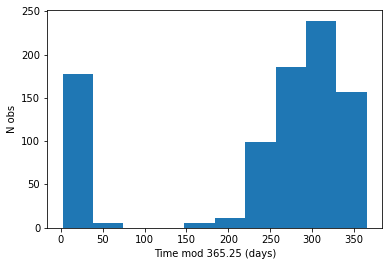

In [8]:
hist = plt.hist(data['observationStartMJD'] % 365.258)
plt.xlabel('Time mod 365.25 (days)')
plt.ylabel('N obs')

Text(0.5, 0, 'Seeing FWHM Geom (arcsec)')

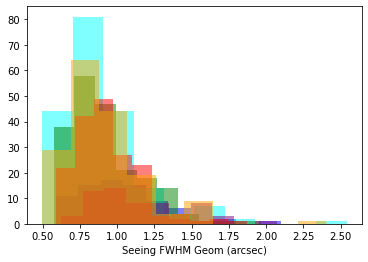

In [9]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

bins = np.arange(0,4, .1)

for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(data['seeingFwhmGeom'][infilt], color=f2c[filtername], alpha=.5)
plt.xlabel('Seeing FWHM Geom (arcsec)')


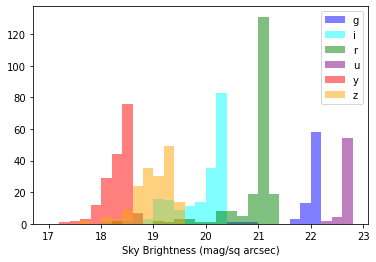

In [10]:
bins = np.arange(17,23, .2)
for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(data['skyBrightness'][infilt], color=f2c[filtername], alpha=.5, bins=bins, label=filtername)
plt.xlabel('Sky Brightness (mag/sq arcsec)')
leg = plt.legend()

Text(0.5, 0, 'airmass')

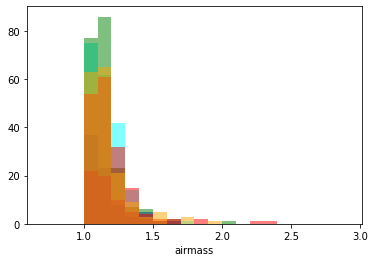

In [11]:
bins = np.arange(.7,3,.1)
for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(data['airmass'][infilt], color=f2c[filtername], alpha=.5, bins=bins)
plt.xlabel('airmass')


Text(0.5, 0, '5-sigma depth')

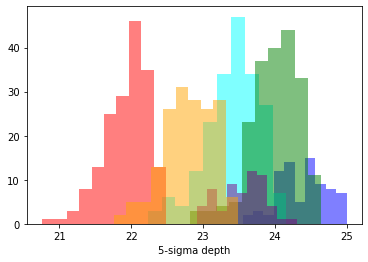

In [12]:
bins = np.arange(20,25,.2)
for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(data['fiveSigmaDepth'][infilt], color=f2c[filtername], alpha=.5, bins=None)
plt.xlabel('5-sigma depth')


Text(0.5, 0, 'SNR')

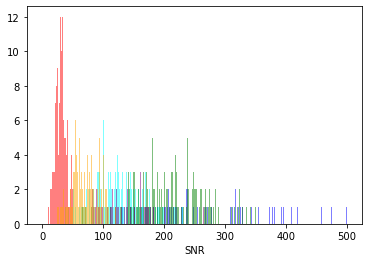

In [13]:
mag = 20  # Assuming a flat SED, mag=20 in all filters
snr = m52snr(mag, data['fiveSigmaDepth'])
bins = np.arange(0,500,1)
for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(snr[infilt], color=f2c[filtername], alpha=.5, bins=bins)
plt.xlabel('SNR')


Text(0.5, 0, 'Centroid precision (mas)')

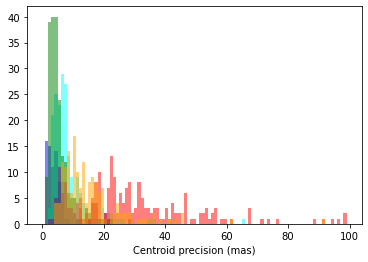

In [14]:
bins = np.arange(0,100, 1)
prec = astrom_precision(data['seeingFwhmGeom'], snr)
# Note, this is just FWHM/SNR. Which almost certainly scales right, but seems like there might
# be factors of 2 or pi that got dropped from that.

for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(prec[infilt]*1000, color=f2c[filtername], alpha=.5, bins=bins)
plt.xlabel('Centroid precision (mas)')


In [15]:
for filtername in np.unique(data['filter']):
    infilt = np.where(data['filter'] == filtername)[0]
    print('%i in %s' % (np.size(infilt), filtername))


77 in g
197 in i
203 in r
60 in u
174 in y
170 in z
